In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(rc={'font.family': 'Ubuntu Mono'})
sns.set_context('notebook')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

In [2]:
df_sales = pd.read_csv("../data/ts-data-few-missings.csv", parse_dates=['date']).set_index('date').loc['2015-07':]
df_holidays = pd.read_csv("../data/ts-holidays.csv", parse_dates=['date'])

## Functions

In [3]:
def forecast_ts_with_prophet(ts_in=Series(), train_period_until='', test_period_from='', holidays_in=''):
    """
    Input
        ts_in: a pandas Series with a valid datetime index
        train_period_until: a string like 'yyyy-mm-dd' representing the end of the train period
        test_period_from: a string like 'yyyy-mm-dd' representing the start of the test period
        holidays: a dataframe with a date column and a holiday flag or column
    
    How it works
        Prepares data in the format that Prophet expects and calls the fit and predict methods to produce a forecast
    
    Output
        A dataframe with date, y, yhat, yhat_upper, yhat_lower
    """
    from fbprophet import Prophet
    
    try:
        print("Removing outliers...")
        ts_in = ts_in.clip_upper(ts_in.quantile(0.99)).clip_lower(ts_in.quantile(0.01))
        print("Imputing missings...")
        ts_in.fillna(method='bfill', inplace=True)

        # create train, test sets
        df = ts_in.loc[:train_period_until].reset_index()
        df.columns = ['ds', 'y']

        df_test = ts_in.loc[test_period_from:].reset_index()
        df_test.columns = ['ds', 'y']
        
        if isinstance(holidays_in, DataFrame):
            print("Preparing Holidays data...")
            holidays = holidays_in.assign(is_holiday = 'holiday')
            holidays.columns = ['ds', 'holiday']
            print("Fitting the model...")
            m = Prophet(yearly_seasonality=True, holidays=holidays)
            m.fit(df)
        else:
            print("No data on holidays")
            print("Fitting the model...")
            m = Prophet(yearly_seasonality=True)
            m.fit(df)

        # Generate Forecast Horizon
        future = m.make_future_dataframe(periods=df_test.shape[0])

        print("Making Predictions")
        forecast = m.predict(future)

        # Create prediction dataframe
        first, last = forecast.ds.describe().loc[['first', 'last']].tolist()

        df_out = \
        pd.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                 pd.concat([df, df_test]).set_index('ds').loc[first:last].reset_index())
        print("Done.")
        return df_out
    except:
        print("An error occurred. Check the input and try again.")

In [4]:
def plot_prophet_output(df_in=DataFrame, show_conf_int=False):
    """
    """
    fig, ax = plt.subplots(figsize=(16, 6))

    ax.plot_date(df_in['ds'], df_in['y'], fmt='k-*', label='y', alpha=0.2)
    ax.plot_date(df_in['ds'], df_in['yhat'], fmt='-', label='yhat')
    if show_conf_int:
        ax.plot_date(df_in['ds'], df_in['yhat_upper'], fmt='--', label='yhat_upper', alpha=0.2)
        ax.plot_date(df_in['ds'], df_in['yhat_lower'], fmt='--', label='yhat_lower', alpha=0.2)
    ax.legend()

In [5]:
def get_perf_metrics(df_predicted):
    """
    """
    y = df_predicted['y'].copy()
    yhat = df_predicted['yhat'].copy()
    
    mse = np.mean((y - yhat)**2)
    perc_err = (100*(y - yhat))/y
    
    return Series({'RMSE': np.sqrt(mse), 'MAPE': np.mean(abs(perc_err))})

## Output

In [6]:
ITEM = Series(df_sales.columns.tolist()).sample(1).iloc[0]
ITEM

'20386898'

In [7]:
df_predicted = forecast_ts_with_prophet(ts_in=df_sales[ITEM], 
                                        train_period_until='2016-11', 
                                        test_period_from='2016-12')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Removing outliers...
Imputing missings...
No data on holidays
Fitting the model...
Making Predictions
Done.


/miniconda/envs/ts-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Ubuntu Mono'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


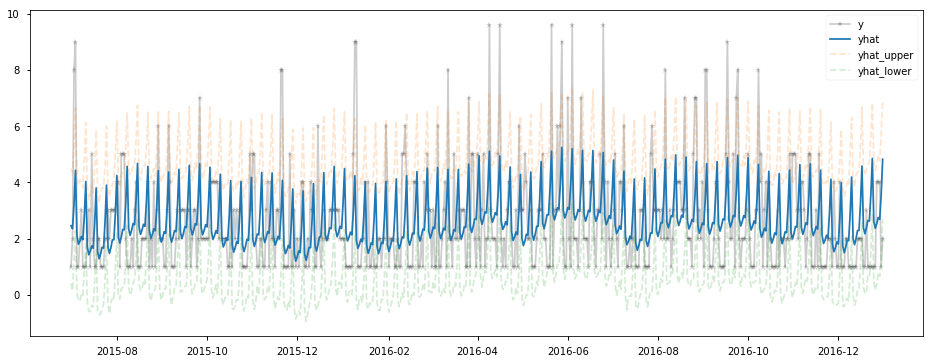

In [8]:
plot_prophet_output(df_in=df_predicted, show_conf_int=True)

In [9]:
get_perf_metrics(df_predicted)

MAPE    66.950205
RMSE     1.624831
dtype: float64

/miniconda/envs/ts-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Ubuntu Mono'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


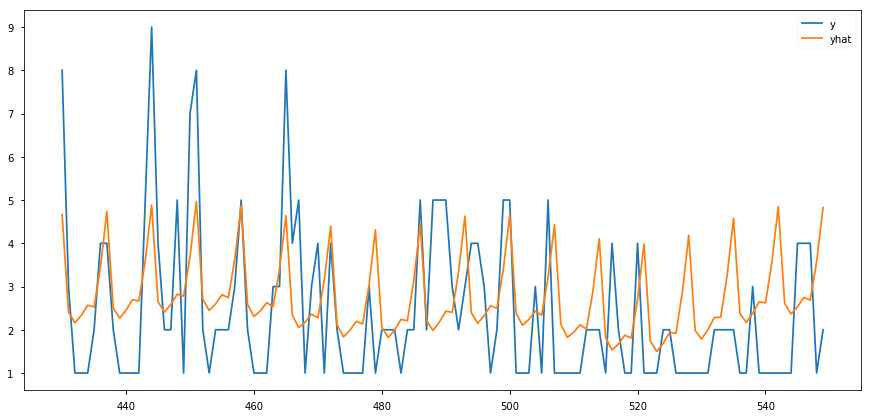

In [10]:
df_predicted.iloc[-120:].loc[:, ['y', 'yhat']].plot(figsize=(15, 7))